In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime
import sys
from normalize_data import getNormalizedDataset

In [17]:

df.shape
df.isnull().sum()

(230396, 18)
(230060, 18)
(230041, 18)
(220417, 19)


titulo                         4900
descripcion                    1437
tipodepropiedad                   0
ciudad                            0
provincia                         0
antiguedad                    39154
habitaciones                      0
garages                           0
banos                             0
metroscubiertos                   0
metrostotales                     0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
precio_m2                         0
precio_dolar                      0
extras                            0
dtype: int64

In [18]:
# Revisemos la cantidad de publicaciones por tipo de propiedad 
# y nos quedamos con las que tengan mas de 1000 publicaciones.
df['mes'] = df['fecha'].dt.month
df['año'] = df['fecha'].dt.year

df3 = df.groupby('tipodepropiedad').agg(promedio_m2=('precio_m2','mean'), tamano=('tipodepropiedad', 'size')).reset_index()
df3.sort_values(by='tamano', ascending=False)

df3[df3['tamano'] < 1000].sort_values(by='tamano')

# Se pueden observar 4 del tipo comerciales. Hagamos un analisis mas profundo al respecto.

,tipodepropiedad,promedio_m2,tamano
22,Hospedaje,10416.67,1
23,Garage,12500.00,1
12,Lote,2383.21,4
8,Huerta,16305.73,17
20,Terreno industrial,27296.35,21
13,Nave industrial,10845.24,56
15,Otros,20387.42,88
5,Departamento Compartido,17705.74,135
11,Local en centro comercial,24613.43,147
17,Rancho,17179.69,152


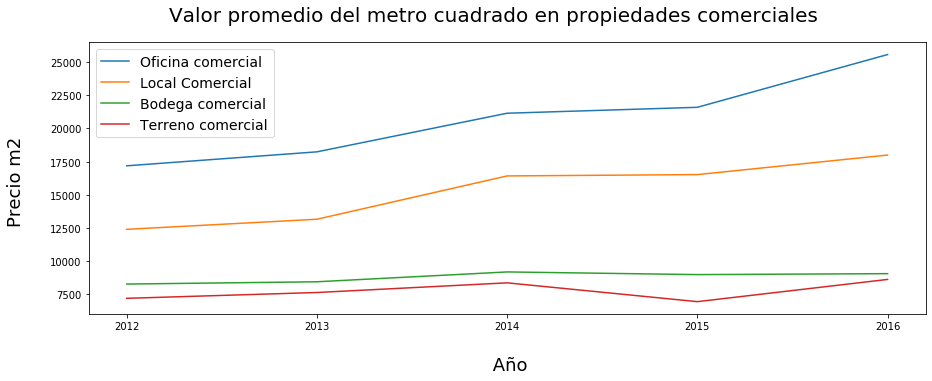

In [19]:
# Me quedo solo con los comerciales y grafico el promedio del m2 en el tiempo para cada uno.
comerciales = df3[(df3['tamano'] < 3000) & (df3['tamano'] > 1000)].sort_values(by="promedio_m2", ascending=False).tipodepropiedad.unique().to_list()
comerciales
dfcomerciales = df[df['tipodepropiedad'].isin(comerciales)]

fig, ax1 = plt.subplots(1,1, figsize=(15,5))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado en propiedades comerciales',fontsize=20)

dfcomerciales = dfcomerciales.groupby(['año', 'tipodepropiedad']).agg(precio_m2=('precio_m2', 'mean')).reset_index()

for i in comerciales: 
    dfplot = dfcomerciales[dfcomerciales['tipodepropiedad'] == i]
    ax1.plot(dfplot.año,\
            dfplot.precio_m2,\
            label=i)

plt.xticks([2012,2013,2014,2015,2016])    
ax1.set_xlabel("\n Año", fontsize=18)
ax1.set_ylabel("Precio m2 \n", fontsize=18)
ax1.legend(loc='best', title_fontsize=16, fontsize=14)

In [20]:

# Resulta interesante entonces que el comportamiento de la Oficina comercial y el del local comercial son similares.
# Mientras que el de el terreno comercial y la bodega comercial tambien son similares.

# Entonces se toma la decision de agrupar oficina comercial y local comercial, bodega comercial y terreno comercial.
# Se remueven todas las otras propiedades.

df.loc[df['tipodepropiedad'] == 'Oficina comercial', ['tipodepropiedad']] = 'Local Comercial'
df.loc[df['tipodepropiedad'] == 'Bodega comercial', ['tipodepropiedad']] = 'Terreno comercial'
df3 = df.groupby('tipodepropiedad').agg(promedio_m2=('precio_m2','mean'), tamano=('tipodepropiedad', 'size')).reset_index()
propiedades_validas = df3[df3['tamano'] > 1000].tipodepropiedad.unique().to_list()

df = df[df['tipodepropiedad'].isin(propiedades_validas)]
df['tipodepropiedad'].cat.remove_unused_categories(inplace=True)
df['tipodepropiedad'].unique()

[Apartamento, Casa en condominio, Casa, Terreno, Local Comercial, Terreno comercial]
Categories (6, object): [Apartamento, Casa en condominio, Casa, Terreno, Local Comercial, Terreno comercial]

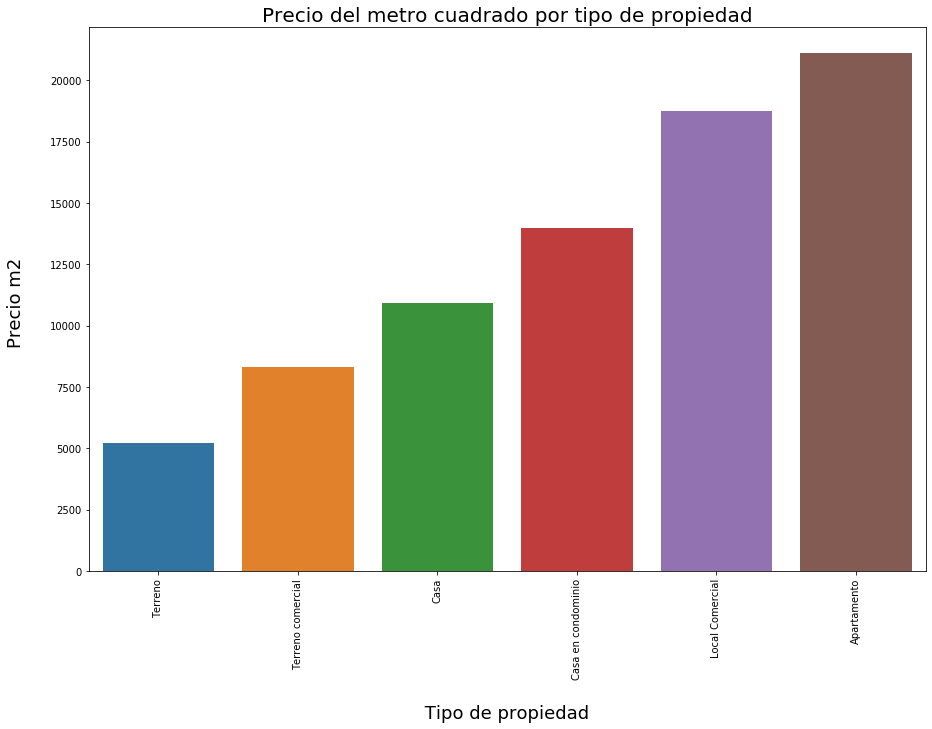

In [21]:
plt.figure(figsize=(15,10))

df2 = df.copy()



df_provs = df2.groupby('tipodepropiedad').precio_m2.mean().reset_index()

df_provs.sort_values(by='precio_m2', inplace=True)

df_provs = df_provs.reset_index(drop=True)

df_provs['tipodepropiedad'] = df_provs['tipodepropiedad'].astype(str)


ax = sns.barplot(data=df_provs, x='tipodepropiedad', y='precio_m2')

ax.set_title('Precio del metro cuadrado por tipo de propiedad', fontdict={'fontsize':20})
ax.set_ylabel('Precio m2 \n', fontsize=18)
ax.set_xlabel('\n Tipo de propiedad ', fontsize=18)

ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [22]:
# Es interesante tambien ver matrices de correlacion por tipo de propiedad.
corr = df.corr()
corr

,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,precio_m2,precio_dolar,extras,mes,año
antiguedad,1.00,0.14,-0.09,-0.04,0.09,0.04,-0.11,-0.10,-0.14,-0.00,-0.01,0.04,0.02,0.04,-0.15,-0.02,-0.05
habitaciones,0.14,1.00,0.32,0.51,0.45,0.25,0.03,0.04,0.04,0.09,0.07,0.21,0.03,0.21,0.28,-0.01,-0.00
garages,-0.09,0.32,1.00,0.34,0.21,0.09,0.07,0.12,0.10,0.12,0.14,0.19,0.16,0.19,0.87,-0.02,-0.05
banos,-0.04,0.51,0.34,1.00,0.53,0.36,0.11,0.11,0.13,0.04,0.03,0.42,0.20,0.42,0.35,-0.00,0.03
metroscubiertos,0.09,0.45,0.21,0.53,1.00,0.82,0.05,0.06,0.08,-0.01,-0.03,0.65,0.12,0.65,0.21,-0.00,0.03
metrostotales,0.04,0.25,0.09,0.36,0.82,1.00,0.02,0.02,0.06,-0.04,-0.07,0.57,-0.08,0.57,0.09,-0.00,0.01
gimnasio,-0.11,0.03,0.07,0.11,0.05,0.02,1.00,0.42,0.37,0.20,0.14,0.19,0.21,0.19,0.44,0.01,0.07
usosmultiples,-0.10,0.04,0.12,0.11,0.06,0.02,0.42,1.00,0.33,0.19,0.23,0.17,0.19,0.17,0.46,0.00,0.01
piscina,-0.14,0.04,0.10,0.13,0.08,0.06,0.37,0.33,1.00,0.18,0.18,0.15,0.12,0.15,0.47,0.01,-0.01
escuelascercanas,-0.00,0.09,0.12,0.04,-0.01,-0.04,0.20,0.19,0.18,1.00,0.78,0.01,0.03,0.01,0.22,-0.01,-0.07


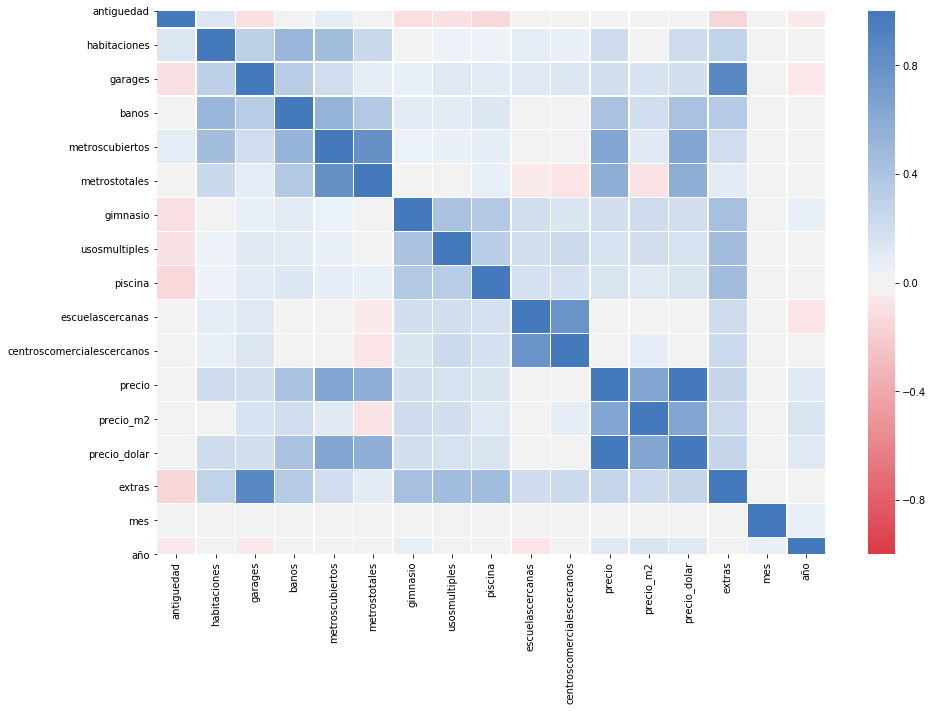

In [23]:
plt.figure(figsize=(15, 10))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap=cmap,
            #annot=True,
            linewidth=0.5,
           vmin=-1,
           vmax=1)


# De este grafico se observa:
# Las correlaciones negativas no son muchas. Principalmente en la antiguedad.
# A menor antiguedad pareceria que hay menor cantidad de extras.
# El precio se ve influenciado principalmente por los metros cubiertos y totales y por la cantidad de baños y habitaciones.
# El resto, no parecen ser lo suficientemente fuerte como para llamar la atencion.

Text(0.5, 1, 'Apartamentos \n')

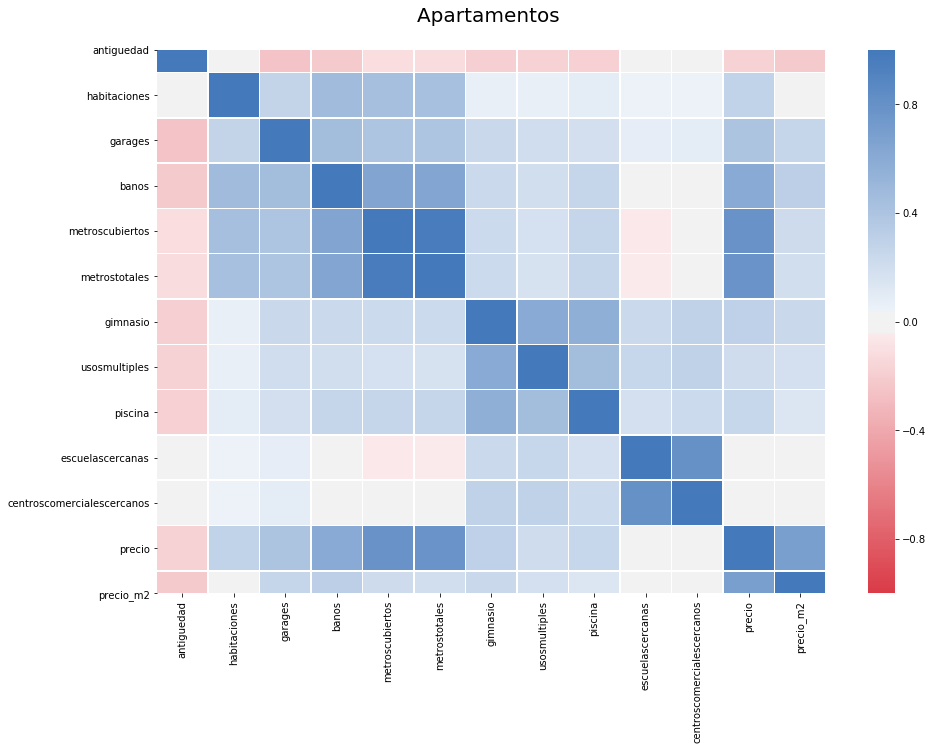

In [24]:
# Y si miro las correlaciones para grupos particulares? Por ejemplo tipos de propiedad?
df2 = df.copy()
df2.drop(columns=['precio_dolar','extras','mes','año'], inplace=True)
corr = df2[df2['tipodepropiedad']=='Apartamento'].corr()
plt.figure(figsize=(15, 10))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
ax = sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap=cmap,
            #annot=True,
            linewidth=0.5,
           vmin=-1,
           vmax=1)

ax.set_title('Apartamentos \n', fontdict={'fontsize':20})

# En los apartamentos, se ve que la correlacion entre la antiguedad y la mayoria de campos (entre ellos el precio) es negativa
# Esto significa que si aumenta la antiguedad, disminuye el precio y los otros campos.

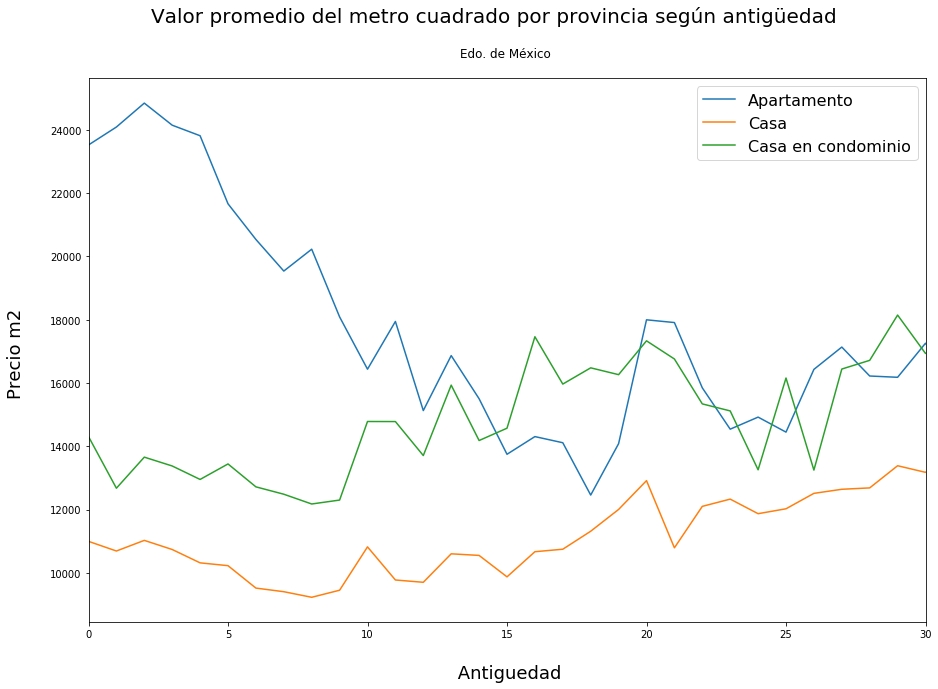

In [25]:
# Ver lo de la antiguedad a nivel mexico general, y ver si es igual a por provincia


df2 = df.copy()

df2 = df2.groupby(['antiguedad','tipodepropiedad']).filter(lambda x: len(x)>10).groupby(['antiguedad','tipodepropiedad']).agg({'precio_m2':'mean'})

df2 = df2.reset_index()

df2.dropna(subset=['precio_m2'], inplace=True)

fig,ax1 = plt.subplots(1,1, figsize=(15,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado por provincia según antigüedad',fontsize=20)

for name in ['Apartamento','Casa', 'Casa en condominio']:
    
    ax1.plot(df2[(df2.tipodepropiedad==name)].antiguedad,\
            df2[(df2.tipodepropiedad==name)].precio_m2,\
            label=name)
    ax1.set_title('Edo. de México \n')
    ax1.set_xlim([0,30])

    
ax1.set_xlabel("\n Antiguedad", fontsize=18)
ax1.set_ylabel("Precio m2 \n", fontsize=18)
ax1.legend(loc='best', fontsize=16)

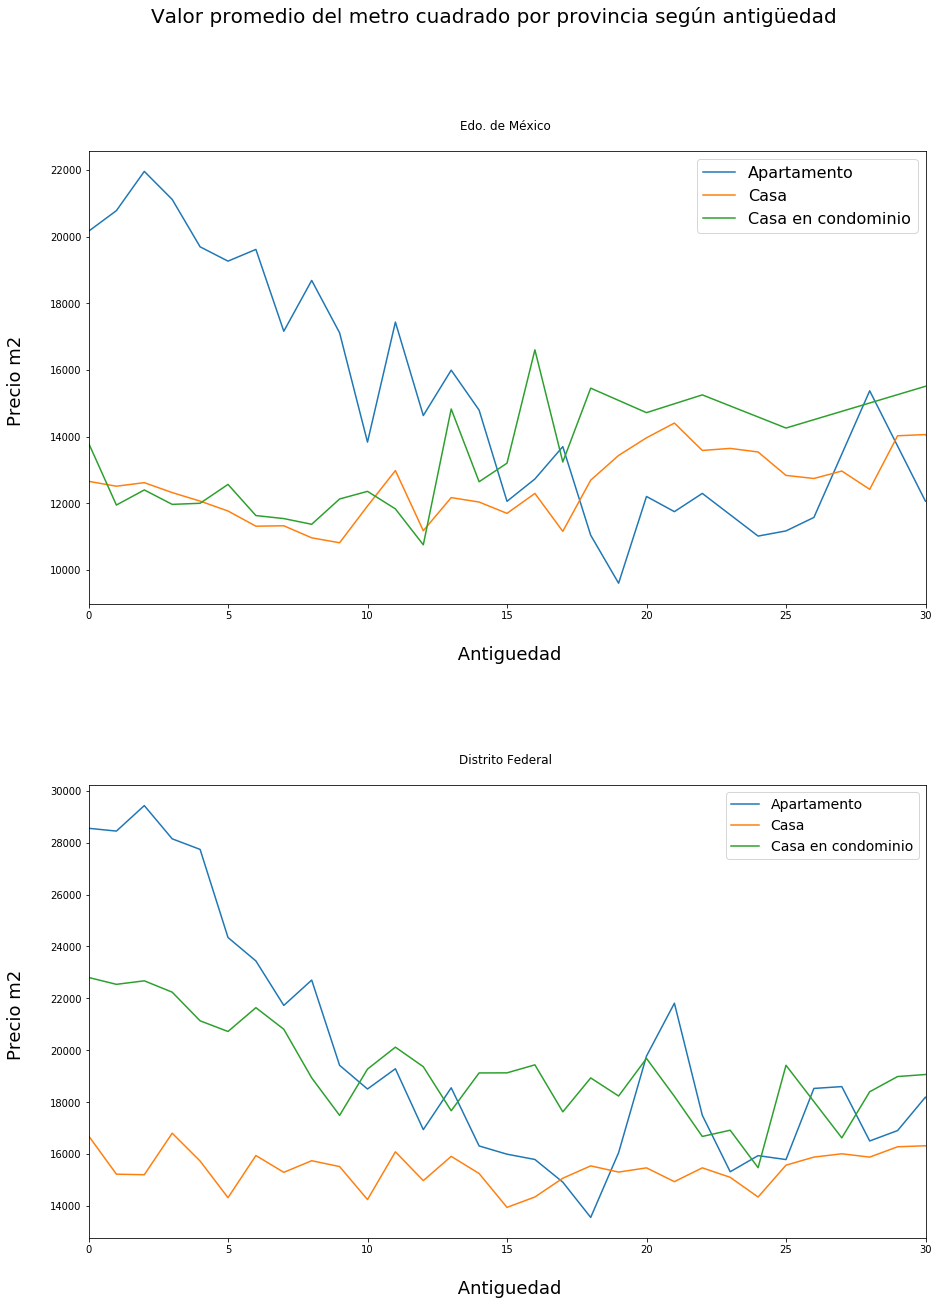

In [26]:
# Influye la antiguedad en el valor de las casas?
# Tomo datos agrupando por antiguedad, tipo de propiedad y provincia. 
# Filtro aquellos grupos donde la cantidad no es suficiente como para hacer un analisis consistente
# Armo un grafico para cada provincia, comparando los tipos de propiedad

df2 = df.copy()

df2 = df2.groupby(['antiguedad','tipodepropiedad','provincia']).filter(lambda x: len(x)>10).groupby(['antiguedad','tipodepropiedad','provincia']).agg({'precio_m2':'mean'})

df2 = df2.reset_index()

df2.dropna(subset=['precio_m2'], inplace=True)

fig,(ax1,ax2) = plt.subplots(2,1, figsize=(15,20))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado por provincia según antigüedad',fontsize=20)

for name in ['Apartamento','Casa', 'Casa en condominio']:
    
    ax1.plot(df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Edo. de México')].antiguedad,\
            df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Edo. de México')].precio_m2,\
            label=name)
    ax1.set_title('Edo. de México \n')

    ax2.plot(df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Distrito Federal')].antiguedad,\
            df2[(df2.tipodepropiedad==name) & (df2.provincia == 'Distrito Federal')].precio_m2,\
            label=name)
    ax2.set_title('Distrito Federal \n')

    ax1.set_xlim([0,30])
    ax2.set_xlim([0,30])

    
ax1.set_xlabel("\n Antiguedad", fontsize=18)
ax1.set_ylabel("Precio m2 \n", fontsize=18)
ax1.legend(loc='best', fontsize=16)
ax2.set_xlabel("\n Antiguedad", fontsize=18)
ax2.set_ylabel("Precio m2 \n", fontsize=18)
ax2.legend(loc='best', fontsize=14)


In [27]:
df.groupby('provincia').describe()['precio_m2']
#ciudad_promedio_preciom2_similar = ['Edo. de México','Guerrero','Jalisco','Nuevo León']


,count,mean,std,min,25%,50%,75%,max
provincia,,,,,,,,
Aguascalientes,1626.00,7778.38,3632.27,1300.05,5333.33,7340.79,9566.79,43650.79
Baja California Norte,3101.00,5937.12,3193.74,972.22,4008.85,5065.58,6857.14,41138.89
Baja California Sur,1640.00,6937.52,4614.20,987.65,3817.62,5745.12,8843.12,45312.50
Campeche,199.00,7679.92,5036.36,916.47,3829.22,6250.00,10669.64,30208.33
Chiapas,1030.00,10245.69,5018.86,1000.00,6500.00,9842.62,13805.42,31100.48
Chihuahua,4327.00,7646.33,4334.85,816.33,4562.29,7041.67,9855.94,44578.95
Coahuila,3516.00,6671.54,3021.35,900.00,4608.07,6333.33,8275.81,30145.63
Colima,933.00,7976.46,5511.90,1000.00,4166.67,6720.00,9943.18,52459.02
Distrito Federal,50035.00,21361.78,10304.74,875.00,13522.23,19444.44,27183.13,57788.94


In [28]:
# Del grafico anterior, se puede observar:
# En ambas ciudades, los precios de los apartamentos van disminuyendo, a la vez que aumenta la antiguedad
# En el caso de las casas, los precios parecen no verse afectados por la antiguedad, pudiendo tener menos o mas valor
# La diferencia de precios, parece verse mas evidente a partir de los 10 años de antiguedad, no asi en los primeros 5.
# No es un dato menor que vaya disminuyendo pero a la vez siga habiendo picos. Si bien es un dato que influye,
# pueden existir casas mas antiguas de mayor valor.

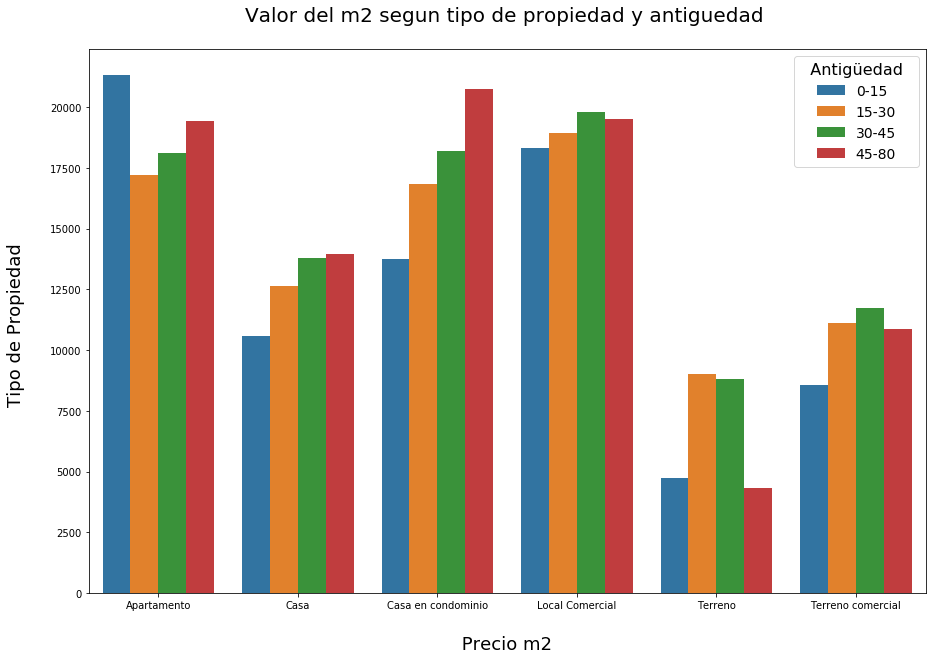

In [29]:
# Se tomn las 10 provincias con mas casas y los 20 tipos de propiedades mas comunes.
# Se evalua el precio del metro cuadrado para cada tipo de propiedad en una provincia distinta

df3 = df.copy()

df3['rango_antiguedad'] = pd.cut(df['antiguedad'],\
                                 bins=[-1,15,30,45,80],\
                                 labels=['0-15', '15-30', '30-45', '45-80'])


plt.figure(figsize=(15,10))
data = df3.groupby(['rango_antiguedad','tipodepropiedad']).agg({'precio_m2':'mean'})
data = data.reset_index()

data.tipodepropiedad.cat.remove_unused_categories(inplace=True)

pivot = data.pivot(index='tipodepropiedad', columns='rango_antiguedad', values='precio_m2')

mask = pivot.isnull()
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
#ax = sns.heatmap(pivot, cmap="YlGnBu")


ax = sns.barplot(data=data, x='tipodepropiedad', y='precio_m2', hue='rango_antiguedad')

ax.set_xlabel('\n Precio m2 ', fontsize=18)
ax.set_ylabel('Tipo de Propiedad \n', fontsize=18)
ax.set_title('Valor del m2 segun tipo de propiedad y antiguedad \n', fontdict={'fontsize':20})
plt.legend(title='  Antigüedad  ', title_fontsize=16, fontsize=14, loc='best')

#ax.set_facecolor('xkcd:grey')


# De este grafico, se puede sacar como informacion:
# Los tres tipos de casas, tienden a incrementar levemente su valor.
# Los apartamentos, y los edificios, tienden a decrementar levemente su valor.
# El resto presentan un comportamiento irregular, del que es dificil predecir algo.

/home/ggparente95/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ggparente95/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([4.902e+03, 4.940e+02, 6.310e+02, 3.666e+03, 3.110e+02, 2.100e+02,
        2.650e+02, 2.051e+03, 1.040e+02, 1.500e+02, 1.270e+02, 2.860e+02,
        5.900e+01, 6.000e+01, 1.230e+02, 7.370e+02, 3.800e+01, 4.400e+01,
        4.000e+01, 1.150e+02, 1.700e+01, 4.300e+01, 1.400e+01, 1.120e+02,
        6.000e+00, 1.200e+01, 3.000e+00, 2.700e+01, 1.000e+00, 4.000e+00,
        1.000e+00, 1.900e+01, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+01]),
 array([ 0.   ,  1.275,  2.55 ,  3.825,  5.1  ,  6.375,  7.65 ,  8.925,
        10.2  , 11.475, 12.75 , 14.025, 15.3  , 16.575, 17.85 , 19.125,
        20.4  , 21.675, 22.95 , 24.225, 25.5  , 26.775, 28.05 , 29.325,
        30.6  , 31.875, 33.15 , 34.425, 35.7  , 36.975, 38.25 , 39.525,
        40.8  , 42.075, 43.35 , 44.625, 45.9  , 47.175, 48.45 , 49.725,
        51.   ]),
 <a list of 40 Patch objects>)

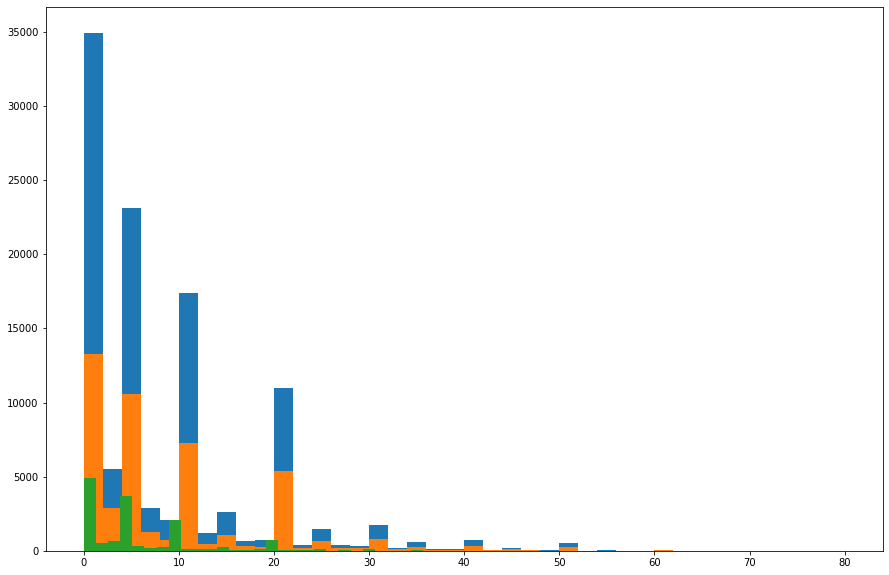

In [30]:
plt.figure(figsize=(15,10))
plt.hist(df[df.tipodepropiedad=='Casa'].antiguedad, bins=40, label='x')
plt.hist(df[df.tipodepropiedad=='Apartamento'].antiguedad, bins=40, label='y')
plt.hist(df[df.tipodepropiedad=='Casa en condominio'].antiguedad, bins=40, label='z')

In [31]:
# Caracteristicas principales de agrupar por habitaciones
# Las casas de mas habitaciones, son mucho mas viejas
# No es algo muy importante, pero es un dato curioso
df.groupby('habitaciones').mean()

,antiguedad,garages,banos,metroscubiertos,metrostotales,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,precio_m2,precio_dolar,extras,mes,año
habitaciones,,,,,,,,,,,,,,,,
0.00,5.76,0.21,0.41,111.95,232.03,0.01,0.00,0.03,0.26,0.24,1842306.56,9963.32,94283.86,0.26,7.64,2014.69
1.00,8.61,0.85,1.11,84.44,102.84,0.11,0.08,0.12,0.40,0.38,1560610.53,18846.95,79867.48,1.16,7.47,2014.75
2.00,7.63,1.17,1.43,94.17,109.13,0.07,0.05,0.07,0.47,0.43,1514436.91,14637.24,77504.45,1.37,7.40,2014.63
3.00,7.13,1.57,2.26,188.83,205.17,0.07,0.06,0.11,0.47,0.42,2559031.10,13727.34,130963.72,1.81,7.38,2014.66
4.00,10.99,1.48,2.59,254.07,268.63,0.06,0.06,0.09,0.49,0.42,3074270.78,13137.45,157332.18,1.69,7.44,2014.69
5.00,14.50,1.30,2.32,265.98,280.01,0.04,0.05,0.05,0.49,0.41,2782663.50,12019.30,142408.57,1.43,7.32,2014.60
6.00,17.19,1.15,2.22,273.71,287.38,0.02,0.03,0.04,0.46,0.36,2665967.75,11857.40,136436.43,1.23,7.36,2014.59
7.00,17.90,1.03,2.14,285.66,300.11,0.02,0.02,0.02,0.46,0.39,2929131.08,12278.80,149904.35,1.08,7.32,2014.59
8.00,18.00,0.96,1.99,282.42,298.52,0.02,0.02,0.03,0.48,0.40,2741645.02,11831.02,140309.37,1.02,7.90,2014.64


In [32]:
# Cantidad de tipos de propiedades
df.tipodepropiedad.value_counts()

Casa                  129590
Apartamento            55106
Casa en condominio     17460
Terreno                 8912
Local Comercial         4139
Terreno comercial       2197
Name: tipodepropiedad, dtype: int64

In [33]:
# Provincias mas grandes
df.groupby(['ciudad']).size().sort_values()[-10:]

ciudad
Atizapán de Zaragoza     5254
Alvaro Obregón           5405
Cuauhtémoc               5532
Naucalpan de Juárez      5551
Monterrey                6160
Mérida                   6756
San Luis Potosí          7160
Benito Juárez            9674
Zapopan                  9688
Querétaro               12150
dtype: int64

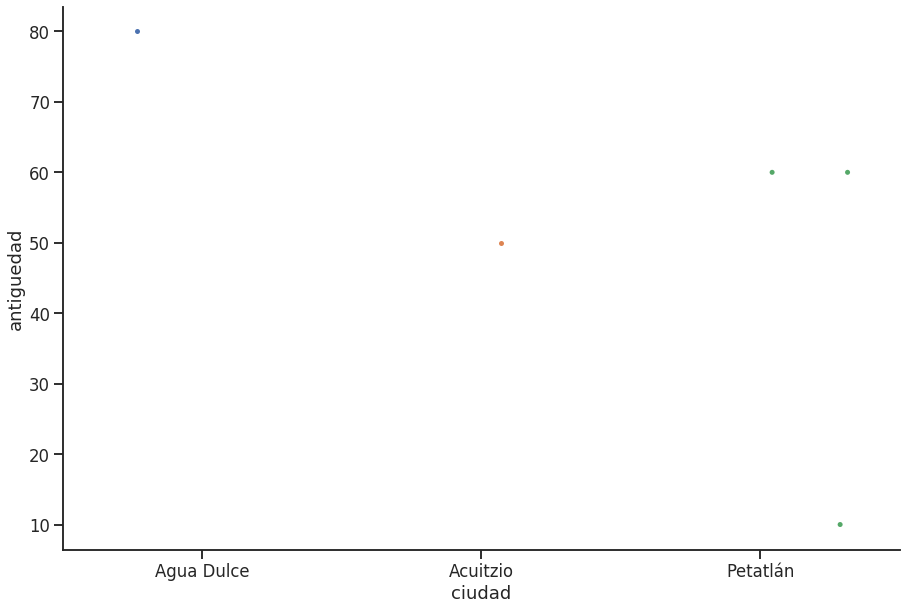

In [34]:

plt.figure(figsize=(15, 10))


top_ciudades_mas_antiguas = df.groupby('ciudad').agg({'antiguedad':'mean'}).sort_values(by='antiguedad',ascending=False)[0:3]
top_ciudades_mas_antiguas = list(top_ciudades_mas_antiguas.index)


df_ciudades = df.loc[df['ciudad'].isin(top_ciudades_mas_antiguas), :]

sns.set(style='ticks', context='talk')

sns.stripplot(x='ciudad', y='antiguedad', data=df_ciudades, jitter=0.35, order=top_ciudades_mas_antiguas)
sns.despine()

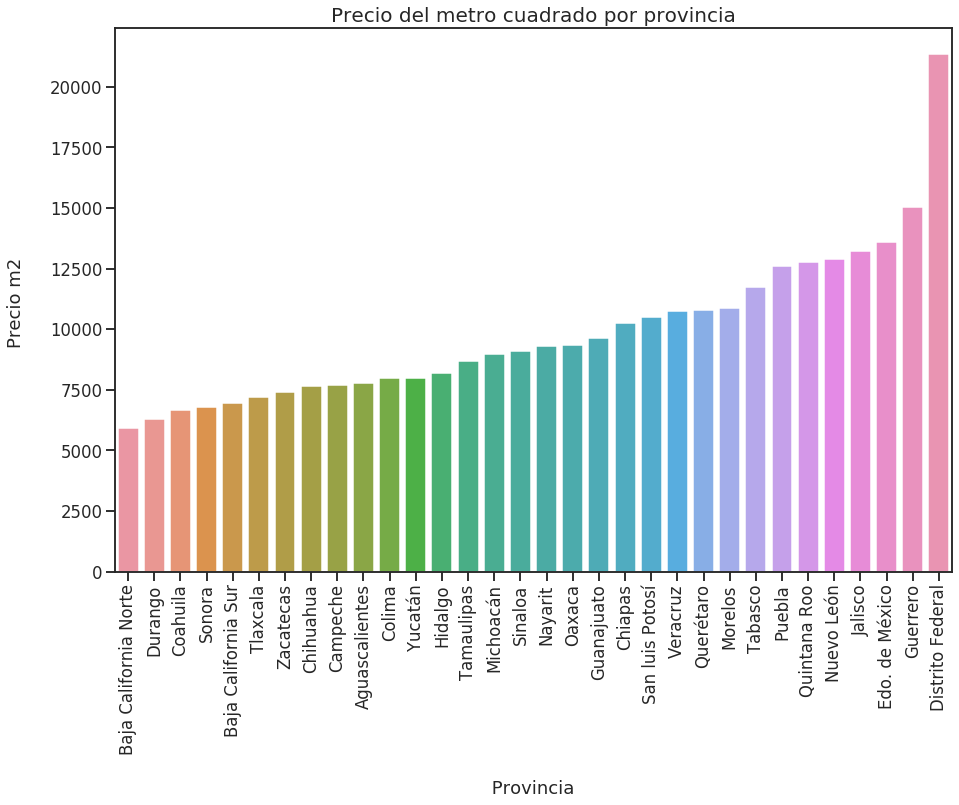

In [35]:


plt.figure(figsize=(15,10))

df2 = df.copy()



df_provs = df2.groupby('provincia').precio_m2.mean().reset_index()

df_provs.sort_values(by='precio_m2', inplace=True)

df_provs = df_provs.reset_index(drop=True)

df_provs['provincia'] = df_provs['provincia'].astype(str)


ax = sns.barplot(data=df_provs, x='provincia', y='precio_m2')

ax.set_title('Precio del metro cuadrado por provincia', fontdict={'fontsize':20})
ax.set_ylabel('Precio m2 \n', fontsize=18)
ax.set_xlabel('\n Provincia ', fontsize=18)

ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

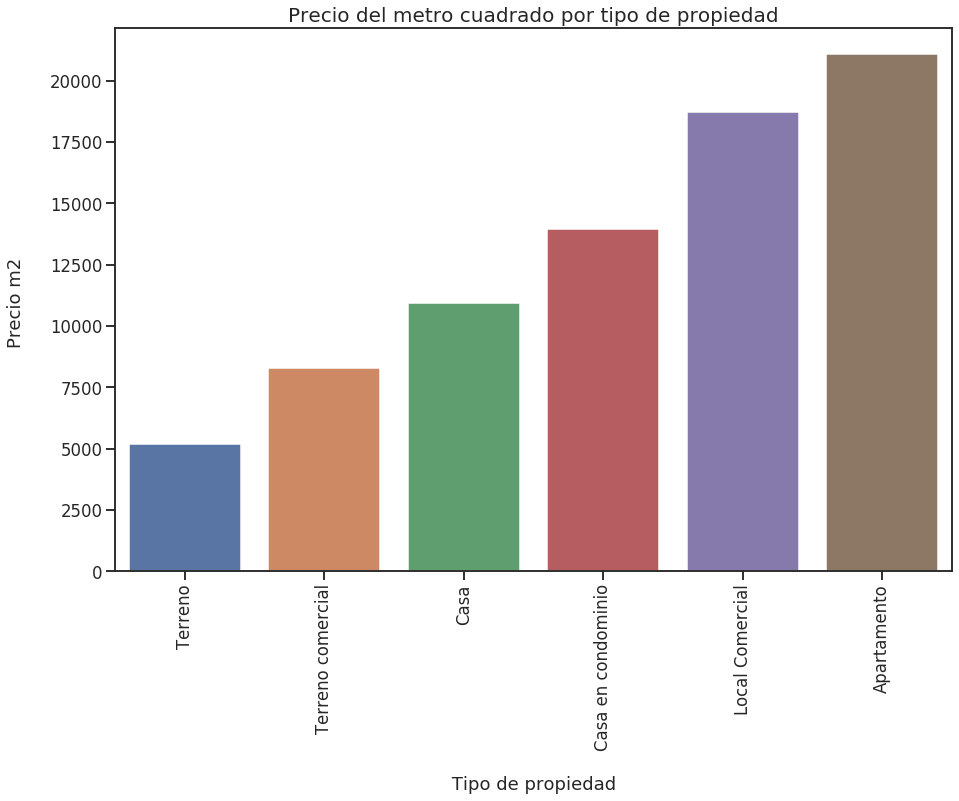

In [36]:
plt.figure(figsize=(15,10))

df2 = df.copy()



df_provs = df2.groupby('tipodepropiedad').precio_m2.mean().reset_index()

df_provs.sort_values(by='precio_m2', inplace=True)

df_provs = df_provs.reset_index(drop=True)

df_provs['tipodepropiedad'] = df_provs['tipodepropiedad'].astype(str)


ax = sns.barplot(data=df_provs, x='tipodepropiedad', y='precio_m2')

ax.set_title('Precio del metro cuadrado por tipo de propiedad', fontdict={'fontsize':20})
ax.set_ylabel('Precio m2 \n', fontsize=18)
ax.set_xlabel('\n Tipo de propiedad ', fontsize=18)

ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

ANALISIS POR CIUDAD Y/O PROVINCIA

In [37]:
df_ciudades = df.groupby(['ciudad','tipodepropiedad']).agg({'precio_m2':'mean'})
df_ciudades

precio_m2
ciudad    tipodepropiedad              
Abalá     Apartamento               nan
          Casa                      nan
          Casa en condominio        nan
          Local Comercial           nan
          Terreno               1575.00
...                                 ...
ZirAndaro Casa                  8527.13
          Casa en condominio        nan
          Local Comercial           nan
          Terreno                   nan
          Terreno comercial         nan

[5250 rows x 1 columns]

In [38]:
top_3_provincias_mas_pobladas = df.groupby('provincia').size().sort_values(ascending=False)[0:3]
top_3_provincias_mas_pobladas = list(top_3_provincias_mas_pobladas.index)
plt.figure(figsize=(20, 10))

df_provincias = df.groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})

df_provincias = df_provincias.reset_index()
df_provincias

,provincia,tipodepropiedad,precio_m2
0,Aguascalientes,Apartamento,13216.45
1,Aguascalientes,Casa,7588.02
2,Aguascalientes,Casa en condominio,9402.97
3,Aguascalientes,Local Comercial,11587.99
4,Aguascalientes,Terreno,3141.11
...,...,...,...
187,Zacatecas,Casa,7485.05
188,Zacatecas,Casa en condominio,6609.54
189,Zacatecas,Local Comercial,17500.00
190,Zacatecas,Terreno,5508.41


<Figure size 1440x720 with 0 Axes>

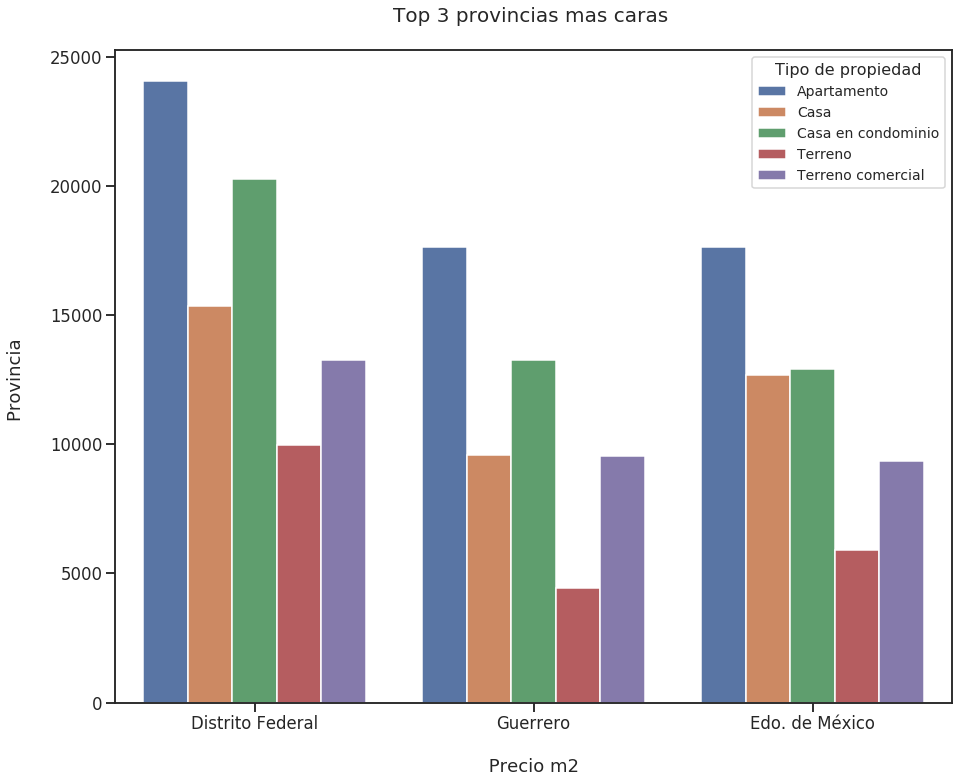

In [39]:
top_3_provincias_mas_caras = df.groupby('provincia').agg({'precio_m2':'mean'}).sort_values(by='precio_m2',ascending=False)[0:3]
top_3_provincias_mas_caras = list(top_3_provincias_mas_caras.index)
plt.figure(figsize=(15, 12))

df_provincias = df.groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})

df_provincias = df_provincias.reset_index()

df_provincias = df_provincias.loc[df_provincias['tipodepropiedad'].isin(['Apartamento','Casa','Casa en condominio','Terreno','Terreno comercial']), :]
df_provincias.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df_provincias.rename(columns={'tipodepropiedad':'Tipo de propiedad'}, inplace=True)

ax = sns.barplot(data=df_provincias, x='provincia', y='precio_m2', hue='Tipo de propiedad', order=top_3_provincias_mas_caras)

ax.set(xlabel='\n Provincia ', ylabel='Precio m2 \n')
ax.set_title('Top 3 provincias mas caras \n', fontdict={'fontsize':20})
ax.set_xlabel('\n Precio m2 ', fontsize=18)
ax.set_ylabel('Provincia \n', fontsize=18)
plt.legend(title='Tipo de propiedad', title_fontsize=16, fontsize=14)
plt.show()


# Este grafico esta de mas ya qe dice lo mismo que el de abajo. Deberia hacer alguno con las ciudades


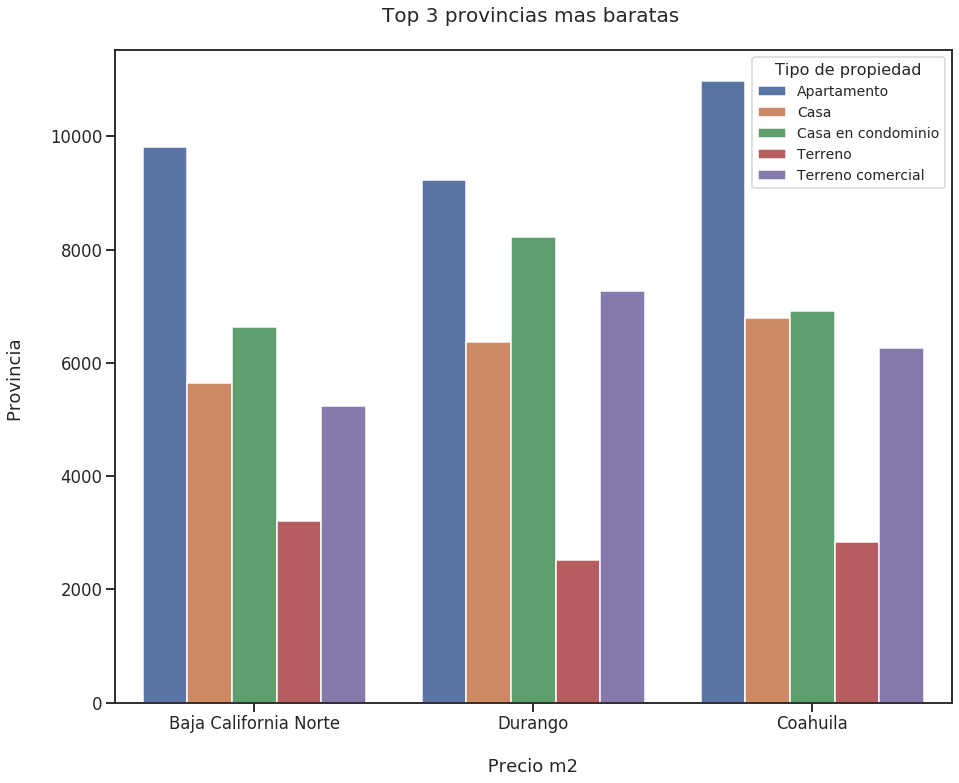

In [40]:
top_3_provincias_mas_caras = df.groupby('provincia').agg({'precio_m2':'mean'}).sort_values(by='precio_m2',ascending=True)[0:3]
top_3_provincias_mas_caras = list(top_3_provincias_mas_caras.index)
plt.figure(figsize=(15, 12))

df_provincias = df.groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})

df_provincias = df_provincias.reset_index()

df_provincias = df_provincias.loc[df_provincias['tipodepropiedad'].isin(['Apartamento','Casa','Casa en condominio','Terreno','Terreno comercial']), :]
df_provincias.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df_provincias.rename(columns={'tipodepropiedad':'Tipo de propiedad'}, inplace=True)

ax = sns.barplot(data=df_provincias, x='provincia', y='precio_m2', hue='Tipo de propiedad', order=top_3_provincias_mas_caras)

ax.set(xlabel='\n Provincia ', ylabel='Precio m2 \n')
ax.set_title('Top 3 provincias mas baratas \n', fontdict={'fontsize':20})
ax.set_xlabel('\n Precio m2 ', fontsize=18)
ax.set_ylabel('Provincia \n', fontsize=18)
plt.legend(title='Tipo de propiedad',title_fontsize=16, fontsize=14, loc='upper right')
plt.show()



In [41]:
# Voy a intentar primero, tener una nocion de como se distribuyen los datos respecto a la antiguedad.
# Se me ocurre un scatter plot de precio y antiguedad pero por categorias (tipos de propiedad)
df.groupby('provincia').describe()['precio_m2'][['count','mean']].sort_values(by='mean')

,count,mean
provincia,,
Baja California Norte,3101.00,5937.12
Durango,2132.00,6298.26
Coahuila,3516.00,6671.54
Sonora,2789.00,6777.12
Baja California Sur,1640.00,6937.52
Tlaxcala,801.00,7214.71
Zacatecas,85.00,7425.09
Chihuahua,4327.00,7646.33
Campeche,199.00,7679.92


/home/ggparente95/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


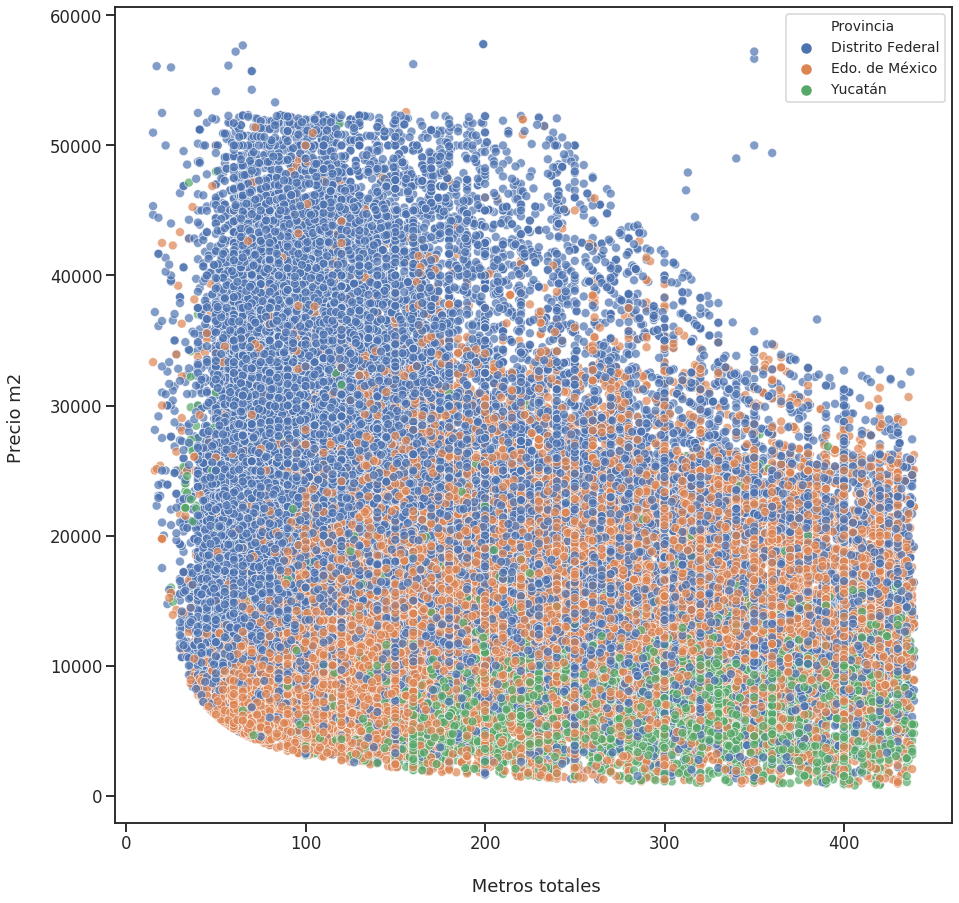

In [42]:
# De lo visto anterior, selecciono tres provincias representativas. Distrito Federal, Coahuila y Yucatán
# Con buen caudal de gente, y con promedios de precios por metro cuadrado distintos.
plt.figure(figsize=(15,15))

data = df[df['provincia'].isin(['Distrito Federal', 'Edo. de México' ,'Yucatán'])]
# Lo hago menro a 90000 ya que, sino, hay algunos datos sueltos que hacne que no se vea tan bien
data = data[df['precio_m2']<=60000]
data.provincia.cat.remove_unused_categories(inplace=True)
data.rename(columns={'provincia':'Provincia'}, inplace=True)

ax = sns.scatterplot(y='precio_m2', x='metrostotales', data=data, hue='Provincia', alpha=0.7)


ax.set_xlabel('\n Metros totales', fontsize=18)
ax.set_ylabel('Precio m2 \n', fontsize=18)
ax.legend(title_fontsize=16, fontsize=14)


# Este scatter plot revela un monton de informacion:
# Primer dato interesante: 
# Las propiedades de mayor valor por metro cuadrado, suelen ser las mas chicas, y las 
# propiedades de menor valor por metro cuadrado, suelen ser las mas grandes.
# Segundo dato curioso: 
# Se puede ver como en Distrito Federal, abundan las propiedades chicas y caras, mientras que en Yucatan hay muchas 
# mas propiedades grandes y con menos valor por metro cuadrado.
# En estado de mexico las casas chicas parecen ser mas baratas que en yucatan y distrito.
# Aca si podria llegar a servir agrupar varias provincias en una para de esa forma poder entender mejor e incluir 
# mucha mas cantidad de datos


Text(100.49999999999999, 0.5, '')

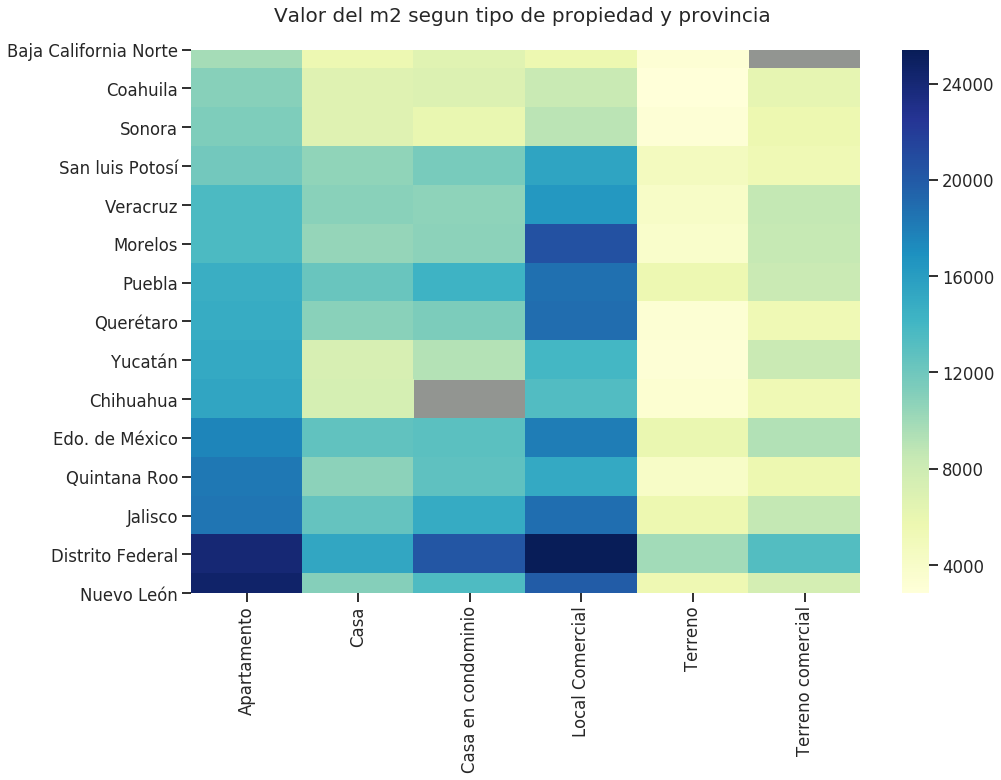

In [43]:
# Se tomn las 10 provincias con mas casas y los 20 tipos de propiedades mas comunes.
# Se evalua el precio del metro cuadrado para cada tipo de propiedad en una provincia distinta

top_10_provincias_mas_pobladas = df.groupby('provincia').size().sort_values(ascending=False)[0:15]
top_10_provincias_mas_pobladas = list(top_10_provincias_mas_pobladas.index)

top_15_tipos_mas_comunes = df.groupby('tipodepropiedad').size().sort_values(ascending=False)[0:15]
top_15_tipos_mas_comunes = list(top_15_tipos_mas_comunes.index)

plt.figure(figsize=(15,10))
data = df.groupby(['provincia','tipodepropiedad']).filter(lambda x: len(x)>10).groupby(['provincia','tipodepropiedad']).agg({'precio_m2':'mean'})
data = data.reset_index()

data = data.loc[data['provincia'].isin(top_10_provincias_mas_pobladas),:]
data = data.loc[data['tipodepropiedad'].isin(top_15_tipos_mas_comunes),:]

data.tipodepropiedad.cat.remove_unused_categories(inplace=True)
data.provincia.cat.remove_unused_categories(inplace=True)

pivot = data.pivot(index='tipodepropiedad', columns='provincia', values='precio_m2')

pivot = pivot.T.sort_values(by='Apartamento').T.T

cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
ax = sns.heatmap(pivot, cmap="YlGnBu")
ax.set_facecolor('xkcd:grey')
ax.set_title('Valor del m2 segun tipo de propiedad y provincia \n', fontdict={'fontsize':20})
ax.set_xlabel('')
ax.set_ylabel('')

# Los grises, son missing values

# Este heatmap revela mucha informacion:
# Ranchos, oficinas y locales, son los mas caros
# Los apartamentos, son mas caros que las casas (raro)
# Distrito Federal, es mas caro que el resto
# Ademas, permite ver la variacion del precio segun el lugar y el tipo.
# Dudas. Esta bien dejar los missing values? o deberia sacar esas categorias?
# Podria mostrar mas informacion, pero los missing values crecen considerablemente

In [44]:
pivot

tipodepropiedad,Apartamento,Casa,Casa en condominio,Local Comercial,Terreno,Terreno comercial
provincia,,,,,,
Baja California Norte,9803.27,5644.37,6633.44,5730.55,3203.00,nan
Coahuila,10972.67,6799.63,6921.15,8343.38,2835.29,6262.41
Sonora,11319.33,6776.84,5932.09,8941.33,3104.92,5743.69
San luis Potosí,11866.42,10626.45,11580.12,15449.74,4692.58,5397.07
Veracruz,13644.56,10941.88,10697.28,16373.31,4153.88,8631.98
Morelos,13657.66,10460.86,10844.71,20607.62,3866.95,8527.89
Puebla,14656.82,12275.34,14348.84,18742.08,5580.20,8265.07
Querétaro,14878.56,10906.63,11410.61,18890.92,3304.77,5426.09
Yucatán,15127.66,7319.58,9208.64,14017.90,3186.78,8258.33


In [45]:
len(list(df['tipodepropiedad'].value_counts().index))

6

In [46]:
df.columns

Index(['titulo', 'descripcion', 'tipodepropiedad', 'ciudad', 'provincia',
       'antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio', 'precio_m2',
       'precio_dolar', 'extras', 'mes', 'año'],
      dtype='object')

In [47]:
df['mes'] = df['fecha'].dt.month
df['año'] = df['fecha'].dt.year

In [48]:
df.groupby(['año','mes']).size()

año   mes
2012  1       1436
      2       1246
      3       1019
      4       1324
      5       1718
      6       1431
      7       1806
      8       3682
      9       2358
      10      2756
      11      1488
      12      1354
2013  1       1848
      2       1288
      3       1579
      4       1682
      5       1839
      6       1831
      7       2340
      8       2187
      9       3057
      10      3691
      11      3689
      12      2894
2014  1       2154
      2       2298
      3       2687
      4       2578
      5       2881
      6       2820
      7       2898
      8       3240
      9       3653
      10      3529
      11      4278
      12      4195
2015  1       3977
      2       3579
      3       3648
      4       3500
      5       3371
      6       3485
      7       3514
      8       4181
      9       4392
      10      5015
      11      4396
      12      3929
2016  1       5275
      2       4166
      3       4487
      4       5986
  

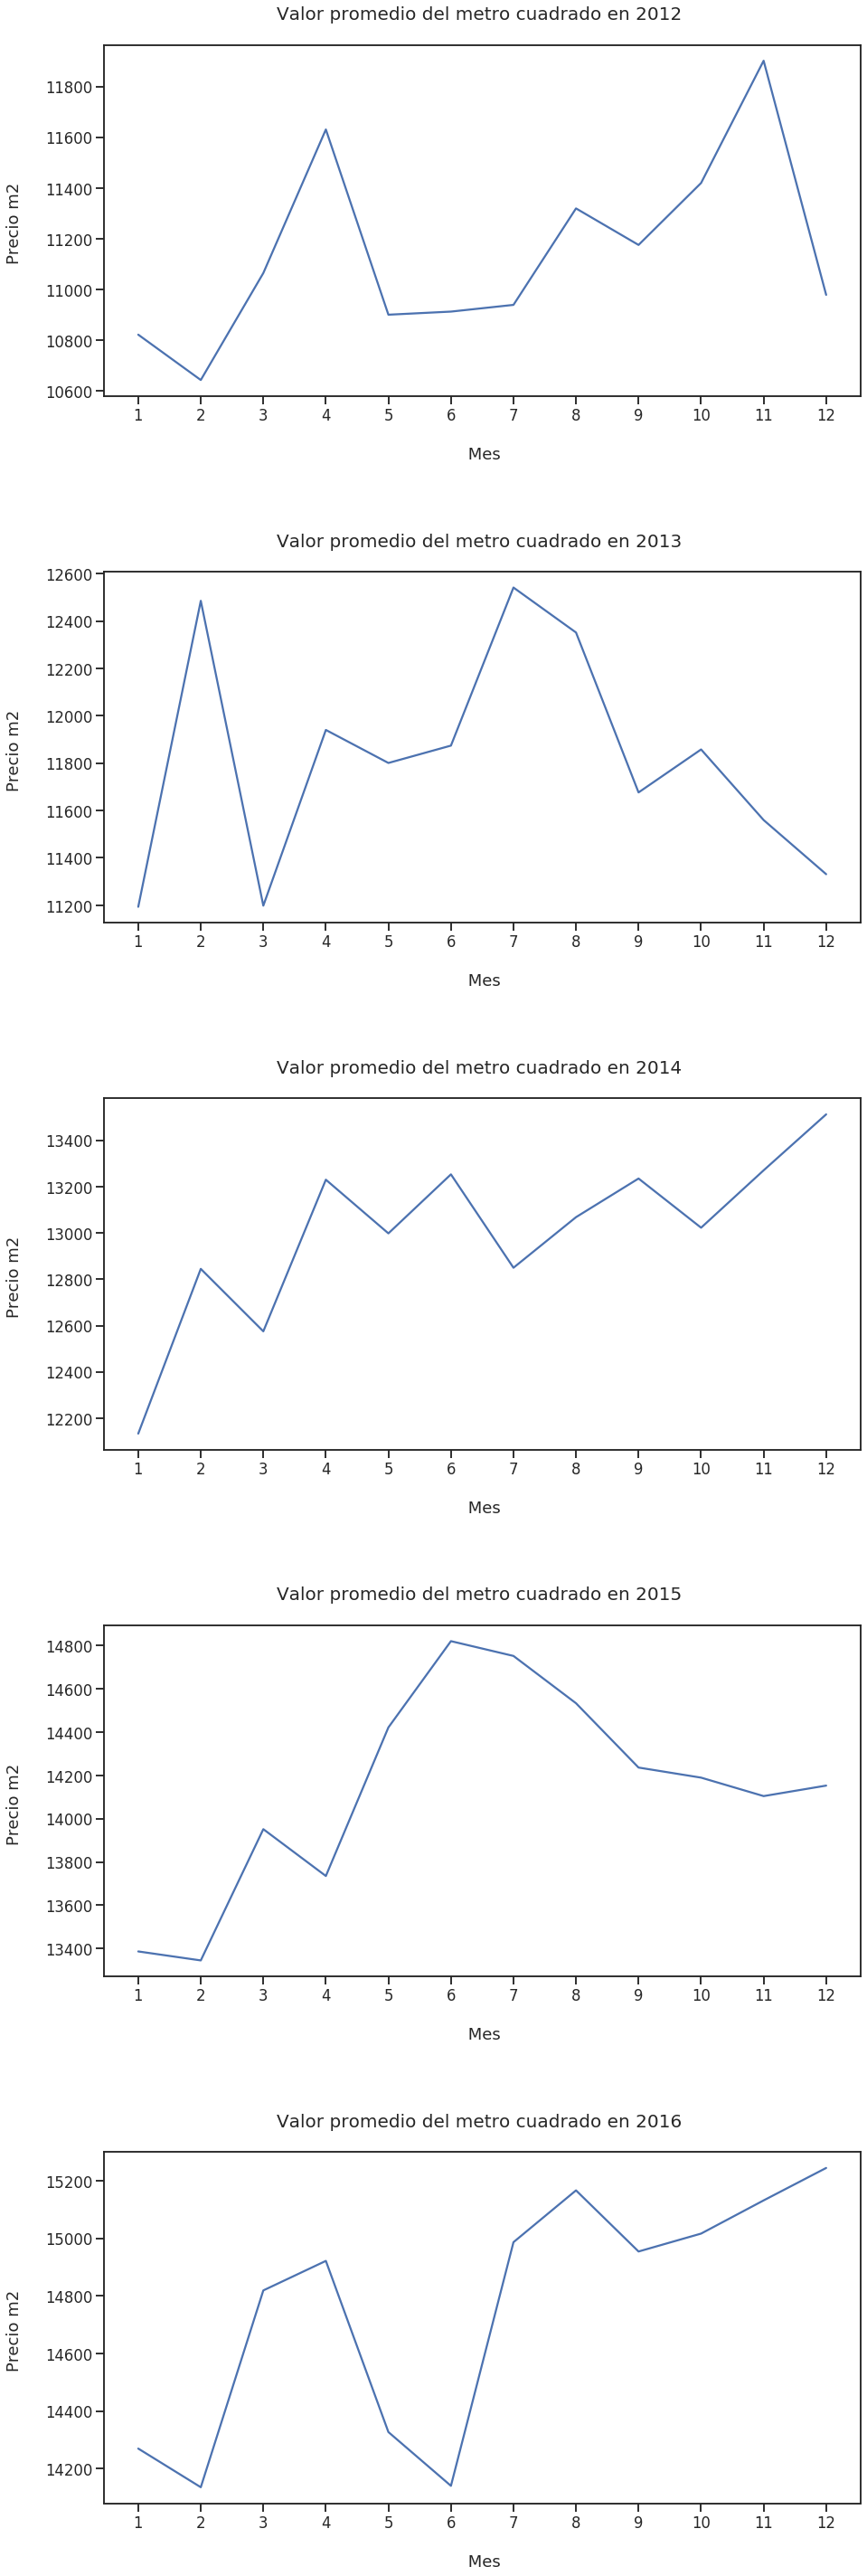

In [50]:
# Como fue variando el precio del metro cuadrado en pesos mexicanos a lo largo de los años?
df2 = df.copy()
df2 = df2.groupby(['año','mes']).agg({'precio_m2':'mean'})
df2 = df2.reset_index()

fig,ax1 = plt.subplots(5,1, figsize=(15,50))
i = 0
plt.setp(ax1, xticks=[1,2,3,4,5,6,7,8,9,10,11,12])
fig.subplots_adjust(hspace=0.5)

for año in [2012,2013,2014,2015,2016]: 
    ax1[i].set_xlabel("\n Mes",fontsize=18)
    ax1[i].set_ylabel("Precio m2 \n",fontsize=18)
    ax1[i].plot(df2[(df2.año==año)].mes,\
            df2[(df2.año==año)].precio_m2,\
            label=name)
    ax1[i].set_title('Valor promedio del metro cuadrado en {} \n'.format(año), fontsize=20)
    plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
    i += 1

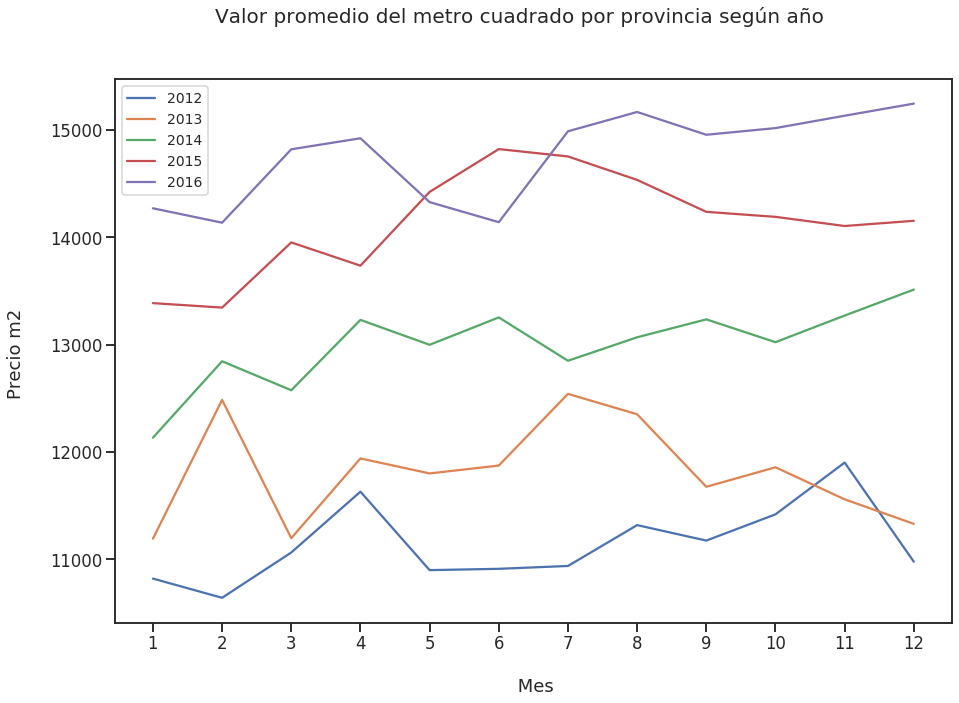

In [51]:
# Como fue variando el precio del metro cuadrado en pesos mexicanos a lo largo de los años?

df2 = df.copy()

df2 = df2.groupby(['año','mes']).agg({'precio_m2':'mean'})

df2 = df2.reset_index()

fig,ax1 = plt.subplots(1,1, figsize=(15,10))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Valor promedio del metro cuadrado por provincia según año',fontsize=20)

for año in [2012,2013,2014,2015,2016]:
    
    ax1.plot(df2[(df2.año==año)].mes,\
            df2[(df2.año==año)].precio_m2,\
            label=año)

plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])    
ax1.set_xlabel("\n Mes", fontsize=18)
ax1.set_ylabel("Precio m2 \n", fontsize=18)
ax1.legend(loc='best', title_fontsize=16, fontsize=14)


# De este grafico se observa:
# Este grafico son todos los anteriores juntos.
# Las 5 lineas, respectivas a cada año, son casi paralelas, y salvo 2013 (se mantiene), todas incrementan.
# Esto nos da la pauta de que año a año los valores de las propiedades, van subiendo.

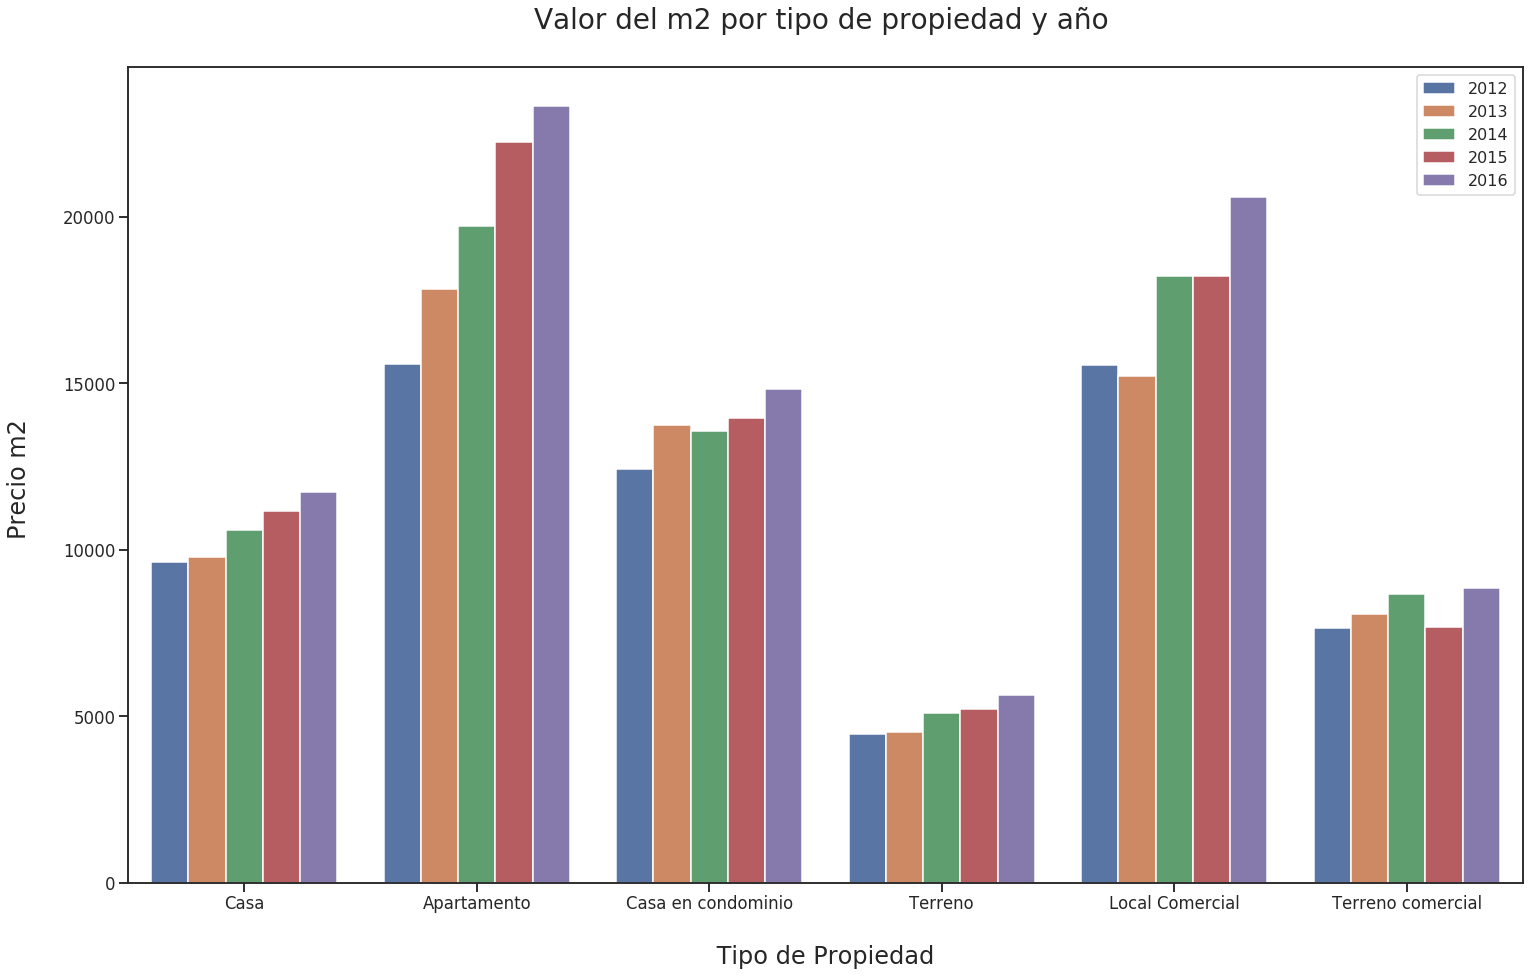

In [52]:
# Y si tomo en cuenta los tipos de propiedades. Todas fueron subiendo de precio? O como se comportaron?
# Filtro para asegurarme de que los grupos que tomo sean de mas de 20 casas

df_años = df.groupby(['año','tipodepropiedad']).filter(lambda x: len(x)>20).groupby(['año','tipodepropiedad']).agg({'precio_m2':'mean'})
top_5_tipos_mas_comunes = df.groupby('tipodepropiedad').size().sort_values(ascending=False)[0:10]
top_5_tipos_mas_comunes = list(top_5_tipos_mas_comunes.index)
plt.figure(figsize=(25, 15))

df_años = df_años.reset_index()

df_años = df_años.loc[df_años['tipodepropiedad'].isin(top_5_tipos_mas_comunes), :]
df_años.tipodepropiedad.cat.remove_unused_categories(inplace=True)

df_años.rename(columns={'tipodepropiedad':'Tipo de propiedad'}, inplace=True)

ax = sns.barplot(data=df_años, x='Tipo de propiedad', y='precio_m2', hue='año', order=top_5_tipos_mas_comunes)

ax.set_xlabel('\n Tipo de Propiedad ', fontsize=24)
ax.set_ylabel('Precio m2 \n', fontsize=24)
ax.set_title('Valor del m2 por tipo de propiedad y año \n', fontdict={'fontsize':28})
ax.legend(loc='best', title_fontsize=18, fontsize=16)
plt.show()

# El grafico muestra, para cada tipo de propiedad y para cada año, como fue variando el precio.
# En todos los casos sube, a excepcion del Terreno Comercial, que, por alguna razon que desconozco, en 2012
# tenia un valor altisimo. Esta anomalía quizas es algo para mirar detenidamente.

# Quizas esto es algo que podriamos ver si, en dolares, tambien subio. Porque puede que sea simplemente por la inflacion
# del peso mexicano


In [53]:
# Existe alguna relacion entre los metros cuadrados de las casas y los años? La idea seria ver si se da que las casas menos antiguas son mas chicas

# Distribucion inicial de los datos (scatter plots, histogramas)

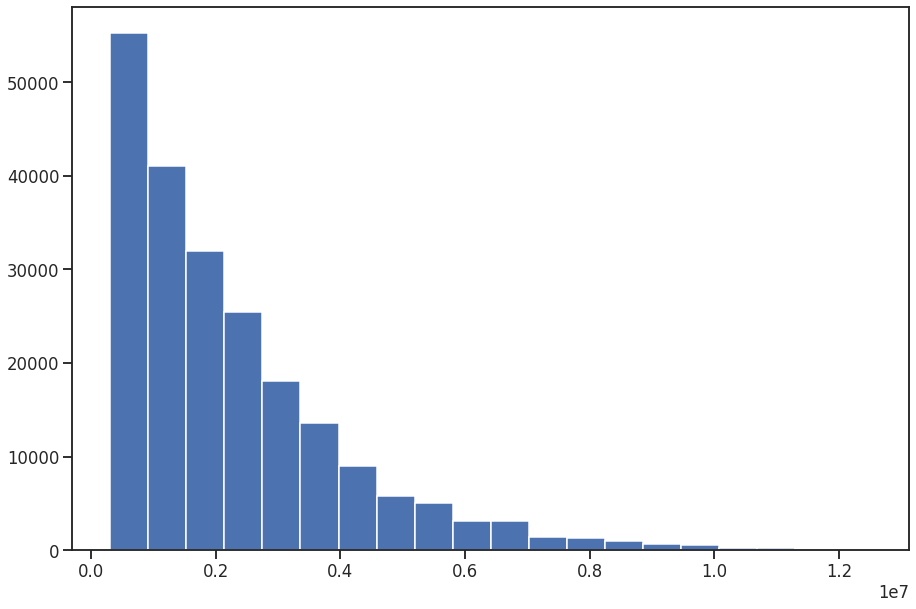

In [54]:

plt.figure(figsize=(15,10))

plt.hist(df.precio, bins=20)
plt.hist


#ax = sns.distplot(a=df.precio)

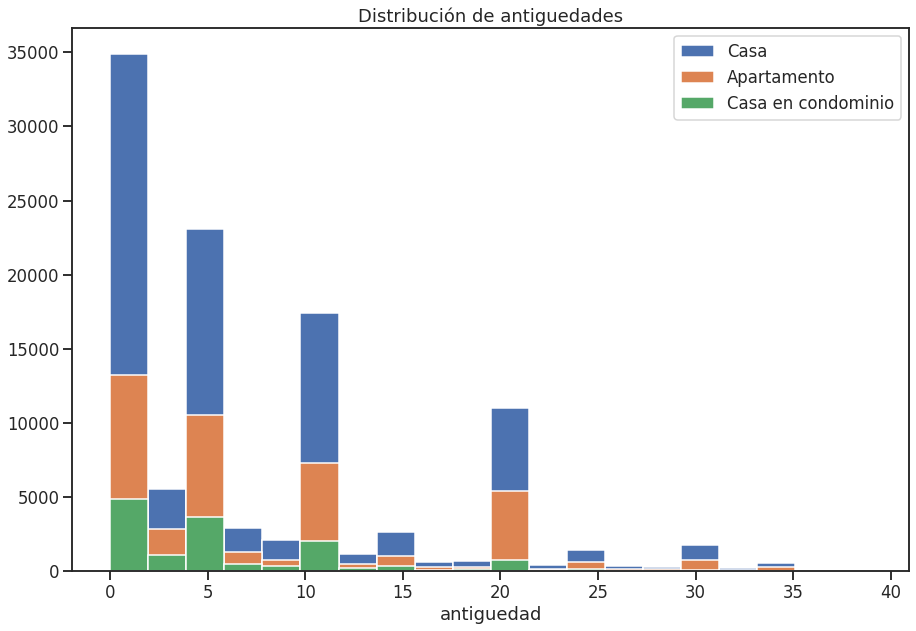

In [165]:
df2 = df.copy()

df2 = df2[df2.antiguedad<40]

df2['antiguedad'] = pd.to_numeric(df2['antiguedad'], errors='coerce')

df2.dropna(subset=['antiguedad'], inplace=True)

df2['antiguedad'] = df2['antiguedad'].astype(int)


plt.figure(figsize=(15,10))


sns.distplot( df2.loc[df2.tipodepropiedad=='Casa'].antiguedad, kde=False, bins=20, hist_kws=dict(alpha=1))
sns.distplot( df2[df2.tipodepropiedad=='Apartamento'].antiguedad, kde=False, bins=20, hist_kws=dict(alpha=1))
sns.distplot( df2.loc[df2.tipodepropiedad=='Casa en condominio'].antiguedad , kde=False, bins=20, hist_kws=dict(alpha=1))

plt.title('Distribución de antiguedades')
plt.legend(['Casa','Apartamento','Casa en condominio']);

# Heatmap antiguedad: provincia-tipo de propiedad

# Se puede ver que la mayor concentracion de propiedades se encuenttra entre los 0-5 anos y se puede ver un claro patron
# de que se mantienen las proporciones de cada tipo de propiedad con la antiguedad. Para una mejor visualizacion se propone
# un grafico de densidad.


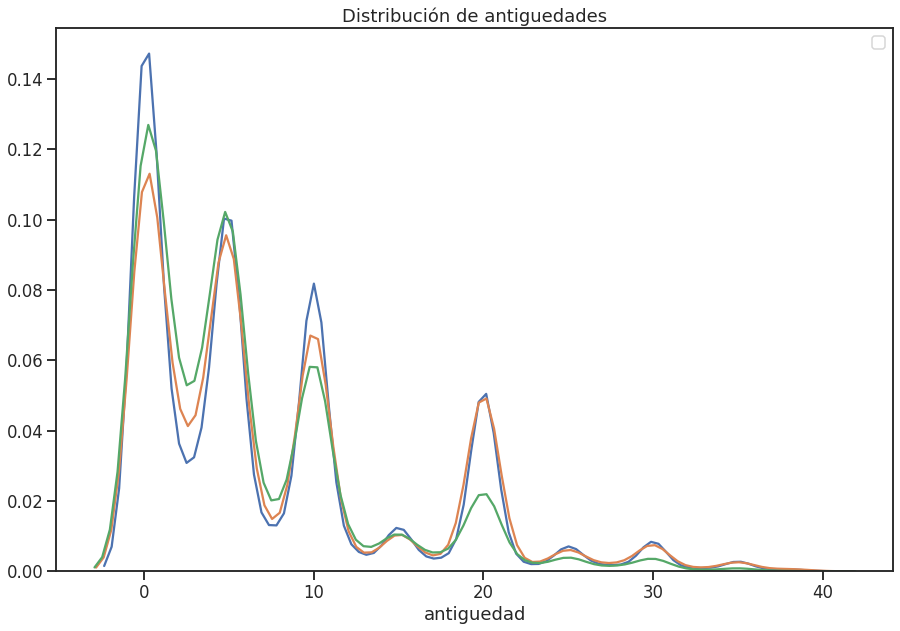

In [166]:
df2 = df.copy()

df2 = df2[df2.antiguedad<40]

df2['antiguedad'] = pd.to_numeric(df2['antiguedad'], errors='coerce')

df2.dropna(subset=['antiguedad'], inplace=True)

df2['antiguedad'] = df2['antiguedad'].astype(int)


plt.figure(figsize=(15,10))


sns.distplot( df2.loc[df2.tipodepropiedad=='Casa'].antiguedad, hist=False, bins=20, hist_kws=dict(alpha=1))
sns.distplot( df2[df2.tipodepropiedad=='Apartamento'].antiguedad, hist=False, bins=20, hist_kws=dict(alpha=1))
sns.distplot( df2.loc[df2.tipodepropiedad=='Casa en condominio'].antiguedad , hist=False, bins=30, hist_kws=dict(alpha=1))

plt.title('Distribución de antiguedades')
plt.legend(['Casa','Apartamento','Casa en condominio']);

# Viendo ahora un grafico de densidad correspondiente a la distribucion de cada tipo de propiedad, se puede ver que 
# porcentualmente se confirma lo antes mencionado. (Si la linea azul fuese casas, el 14% de las casas tienen antiguedad 0
# el 10% )
# Se 
# ESto se puede enter: 
# * Considerando que la probabilidad de que alguien haya cargado una propiedad de 5 anos es la misma que la de alguin
#   que cargo una de 10 anos. Se podria tomar este grafico como la evolucion temporal 

In [ ]:
Jitter plot tipo de propiedad vs precio antiguedad

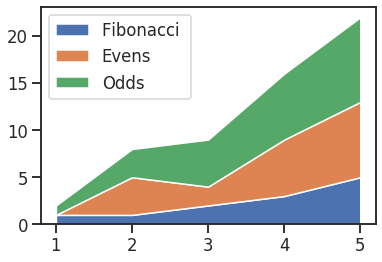

In [180]:
# Ya se me va a ocurrir algo con el diagrama de area

x = [1, 2, 3, 4, 5]
y1 = [1, 1, 2, 3, 5]
y2 = [0, 4, 2, 6, 8]
y3 = [1, 3, 5, 7, 9]

y = np.vstack([y1, y2, y3])

labels = ["Fibonacci ", "Evens", "Odds"]

fig, ax = plt.subplots()
ax.stackplot(x, y1, y2, y3, labels=labels)
ax.legend(loc='upper left')
plt.show()



In [179]:

#df.groupby(['tipodepropiedad','antiguedad']).size().to_frame().reset_index().rename(columns={0:'count'})

fig, ax = plt.subplots(1,1,figsize=(15,10))

for x in df['tipodepropiedad'].value_counts().index.to_list():
    ax.plot()

['Casa',
 'Apartamento',
 'Casa en condominio',
 'Terreno',
 'Local Comercial',
 'Terreno comercial']